In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import glob as gb
import seaborn as sns
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

2023-04-17 13:04:07.974696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMG_SIZE = 128
SEED = 1000
BATCH_SIZE = 32

TRAIN_DIR = '/Users/paris/Desktop/os/train'
TEST_DIR = '/Users/paris/Desktop/os/test'

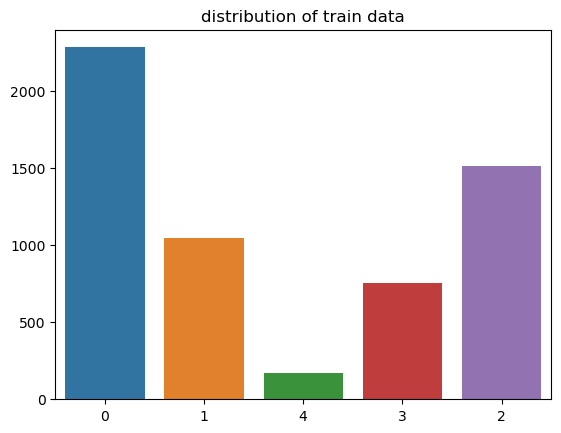

5778


In [4]:
categories = []
class_count = []
train_exm = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*.png'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")

plt.show()

print(train_exm)

In [5]:
train_gen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2,
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)

test_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
    # dtype = tf.float32
)


In [6]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'training',
    seed = SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    subset = 'validation',
    seed = SEED
)
test_batch = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)


Found 4624 images belonging to 5 classes.
Found 1154 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [7]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False,  weights='imagenet')
base_model.summary()

2023-04-17 13:04:17.611263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [8]:
inputs = tf.keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

In [9]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [10]:
h = model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,
)

20/20 [==============================] - 178s 9s/step - loss: 3.4155 - accuracy: 0.2734 - val_loss: 1.4244 - val_accuracy: 0.4141


In [11]:
img_shape = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = True  
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [12]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                           

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [16]:
h = model.fit(
    train_batch,
    steps_per_epoch = 642 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=158 // BATCH_SIZE,
)

20/20 [==============================] - 194s 10s/step - loss: 1.4974 - accuracy: 0.3391 - val_loss: 1.4663 - val_accuracy: 0.3828


Here, by freezing layer the accuracy was 0.2734 and without freezing layers the accuracy is 0.3391 .